This notebook contains code from the train.py file in the same directory for training the ensemble of models used to predict water temperature

In [1]:
from matplotlib import pyplot as plt
from pandas import read_parquet 
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 
import numpy as np 
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

pd.set_option('display.max_rows', 500)
pd.set_option("display.max_columns", 100)

RES_PATH = '../../res/'

Load cleaned data

In [2]:
df = pd.read_parquet(RES_PATH + 'df_pixel.parquet')
df.head()

,date,dd55xcg,dd55zb7,dd55zyg,dd57673,dd5775k,dd577gq,dd5789v,dd5793z,dd57b8m,dd57bwv,dd57c2r,dd57cqz,dd57d3c,dd57e1u,dd57ecy,dd57f23,dd57fqc,dd57g0k,dd57gbq,dd57gnu,dd57gyy,dd57kg2,dd57me6,dd57nku,dd57phy,dd57q7k,dd57r5q,dd57scb,dd57t9f,dd57ub2,dd57uyb,dd57v86,dd57vwf,dd57w3u,dd57x1y,dd57y2k,dd57yqu,dd57z0q,dd57zny,dd5dfqr,dd5dgq3,dd5dun7,dd5duyq,dd5dvy2,dd5dwxd,dd5dxrs,dd5dyw6,dd5dzqk,dd5e0hc,...,dehth48,dehw0er,dehw1e3,dehw29z,dehw39c,dehw47k,dehw63u,dehw88r,dehw8xp,dehw983,dehw9x1,dehwbtx,dehwct9,dehx0sp,dehx2dx,dehx89p,dek00ku,dek01hy,dek027k,dek035q,dek04hb,dek04uf,dek05sv,dek0652,dek06g6,dek07em,dek083u,dek091y,dek0b2k,dek0c0q,dek0d1b,dek0dcf,dek0e9v,dek0f02,dek0fb6,dek0hkz,dek0jkc,dek0k7r,dek0m73,dek0nhg,dek0nuv,dek0psz,dek0q57,dek0qgm,dek0rer,dek0s3z,dek0t3c,dek20sf,dek21ku,dek24hy
0,2000-01-01,26.693710,26.681581,26.681581,26.697742,26.697742,26.705161,26.695484,26.695484,26.681581,26.681581,26.681581,26.681581,26.697742,26.697742,26.705161,26.677355,26.677355,26.677355,26.680968,26.677355,26.680968,26.705161,26.705161,26.714387,26.714387,26.714387,26.714387,26.705161,26.705161,26.680968,26.680968,26.680968,26.680968,26.714387,26.714387,26.687710,26.687710,26.687710,26.687710,26.708581,26.715742,26.715742,26.715742,26.723032,26.723032,26.735355,26.723032,26.735355,26.716903,...,25.905226,25.927581,25.927581,25.961129,25.961129,25.922290,25.961645,25.961129,25.975129,25.961129,25.975129,25.975129,25.975129,25.983323,25.983323,25.983323,25.945839,25.945839,25.945839,25.945839,25.967000,25.967000,25.965419,25.967000,25.967000,25.965419,25.925323,25.925323,25.925323,25.925323,25.937000,25.937000,25.942129,25.937000,25.937000,25.965419,25.965419,25.965419,25.965419,25.968710,25.968710,25.964258,25.968710,25.968710,25.964258,25.942129,25.942129,25.964258,25.972548,25.972548
1,2000-02-01,25.859448,25.944000,25.944000,26.149759,26.149759,26.252552,25.964828,25.964828,26.083759,26.083759,26.083759,26.083759,26.149759,26.149759,26.252552,26.241000,26.241000,26.241000,26.289828,26.241000,26.289828,26.252552,26.252552,26.293483,26.293483,26.293483,26.293483,26.252552,26.252552,26.289828,26.289828,26.289828,26.289828,26.293483,26.293483,26.322966,26.322966,26.322966,26.322966,26.342379,26.349069,26.349069,26.349069,26.331034,26.331034,26.345931,26.331034,26.345931,26.344690,...,25.581207,25.533793,25.533793,25.503103,25.503103,25.525690,25.493448,25.503103,25.481345,25.503103,25.481345,25.481345,25.481345,25.422138,25.422138,25.422138,25.452517,25.452517,25.452517,25.452517,25.427586,25.427586,25.395483,25.427586,25.427586,25.395483,25.474621,25.474621,25.474621,25.474621,25.459828,25.459828,25.431379,25.459828,25.459828,25.395483,25.395483,25.395483,25.395483,25.358448,25.358448,25.331931,25.358448,25.358448,25.331931,25.431379,25.431379,25.331931,25.314241,25.314241
2,2000-03-01,26.409710,26.386871,26.386871,26.402806,26.402806,26.351032,26.422097,26.422097,26.392419,26.392419,26.392419,26.392419,26.402806,26.402806,26.351032,26.368290,26.368290,26.368290,26.319000,26.368290,26.319000,26.351032,26.351032,26.293161,26.293161,26.293161,26.293161,26.351032,26.351032,26.319000,26.319000,26.319000,26.319000,26.293161,26.293161,26.266387,26.266387,26.266387,26.266387,26.182903,26.134968,26.134968,26.134968,26.154226,26.154226,26.164839,26.154226,26.164839,26.228323,...,25.293677,25.341452,25.341452,25.345129,25.345129,25.296258,25.309226,25.345129,25.355129,25.345129,25.355129,25.355129,25.355129,25.352516,25.352516,25.352516,25.367613,25.367613,25.367613,25.367613,25.359774,25.359774,25.359645,25.359774,25.359774,25.359645,25.368065,25.368065,25.368065,25.368065,25.367645,25.367645,25.374355,25.367645,25.367645,25.359645,25.359645,25.359645,25.359645,25.351323,25.351323,25.350419,25.351323,25.351323,25.350419,25.374355,25.374355,25.350419,25.373452,25.373452
3,2000-04-01,26.154400,26.174433,26.174433,26.218167,26.218167,26.272400,26.174733,26.174733,26.208933,26.208933,26.208933,26.208933,26.218167,26.218167,26.272400,26.276100,26.2

<AxesSubplot:xlabel='date'>

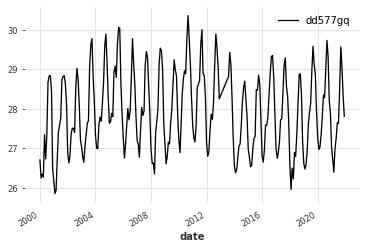

In [3]:
df[['dd577gq', 'date']].set_index('date').plot()

In [4]:
df.iloc[:, 0:10]

,date,dd55xcg,dd55zb7,dd55zyg,dd57673,dd5775k,dd577gq,dd5789v,dd5793z,dd57b8m
0,2000-01-01,26.693710,26.681581,26.681581,26.697742,26.697742,26.705161,26.695484,26.695484,26.681581
1,2000-02-01,25.859448,25.944000,25.944000,26.149759,26.149759,26.252552,25.964828,25.964828,26.083759
2,2000-03-01,26.409710,26.386871,26.386871,26.402806,26.402806,26.351032,26.422097,26.422097,26.392419
3,2000-04-01,26.154400,26.174433,26.174433,26.218167,26.218167,26.272400,26.174733,26.174733,26.208933
4,2000-05-01,27.341000,27.334821,27.334821,27.352821,27.352821,27.344679,27.344750,27.344750,27.341036
5,2000-06-01,26.646300,26.656300,26.656300,26.713300,26.713300,26.730367,26.663000,26.663000,26.692867
6,2000-07-01,27.426387,27.385742,27.385742,27.364548,27.364548,27.346613,27.405452,27.405452,27.369839
7,2000-08-01,28.914258,28.811548,28.811548,28.782355,28.782355,28.679323,28.840387,28.840387,28.752226
8,2000-09-01,28.802667,28.801100,28.801100,28.802833,28.802833,28.831967,28.777833,28.777833,28.818733
9,2000-10-01,28.961903,28.903194,28.903194,28.893516,28.893516,28.836290,28.935387,28.935387,28.877323


In [5]:
# necessary so that DARTS TimeSeries object aligns time
df = df.set_index('date')

In [6]:

def prepare_input(df, start_col=0, end_col=1000):
    df = df.set_index('date')
    transformer = Scaler() 
    train, val = df.iloc[161:245, start_col:end_col], df.iloc[245:,start_col:end_col]
    train = TimeSeries.from_dataframe(train, freq='MS')
    val = TimeSeries.from_dataframe(val, freq='MS')

    train_ts = transformer.fit_transform(train)
    val_ts = transformer.transform(val)
    year_series = datetime_attribute_timeseries(
        pd.date_range(start=train_ts.start_time(), freq=train_ts.freq_str, periods=96),
        attribute="year",
        one_hot=False,
    )
    year_series = Scaler().fit_transform(year_series)
    month_series = datetime_attribute_timeseries(
        year_series, attribute="month", one_hot=True
    )
    covariates = year_series.stack(month_series)
    cov_train, cov_val = covariates.split_after(pd.Timestamp("20201201"))

    return (train_ts, val_ts), (cov_train, cov_val), covariates

In [8]:
def build_model(n_epochs=100):
    return RNNModel(
        model="GRU",
        hidden_dim=2000,
        dropout=0.1,
        batch_size=16,
        n_epochs=n_epochs,
        optimizer_kwargs={"lr": 1e-3},
        model_name="Air_RNN",
        log_tensorboard=True,
        random_state=42,
        training_length=12,
        input_chunk_length=10,
        force_reset=True,
        save_checkpoints=True,
    )
    

Epoch 499: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s, loss=0.000409, v_num=logs]
Predicting: 5it [00:00, ?it/s]


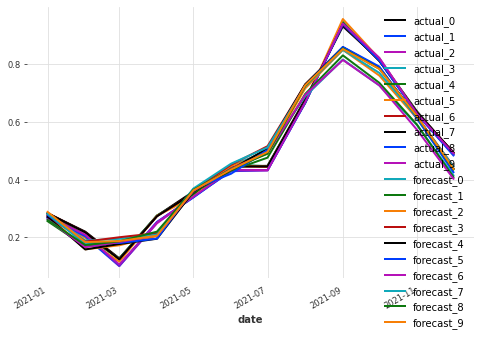

13.936831291527556
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]it/s, loss=0.208, v_num=logs]


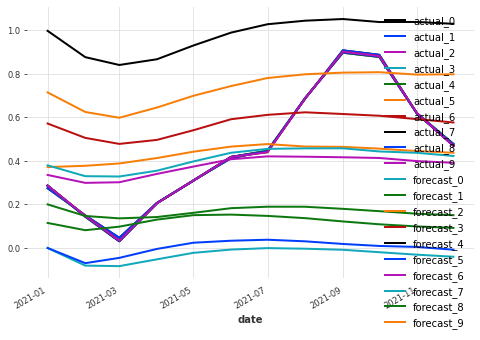

870.7155036425306
Epoch 1:  40%|████      | 2/5 [00:01<00:02,  1.34it/s, loss=0.19, v_num=logs] 

In [9]:
import darts 
import pickle 

def eval_model(model, val_ts):
        pred_series = model.predict(n=12, future_covariates=covariates)
        plt.figure(figsize=(8, 5))
        val_ts.plot(label="actual")
        pred_series.plot(label="forecast")
        plt.legend()
        plt.show(block=True)
        return darts.metrics.mape(pred_series, val_ts)

for start in range(0, 14000, 1000):
    (train_ts, val_ts), (cov_train, cov_val), covariates = prepare_input(df, start, start+1000)
    
    model = build_model()

    model.fit(
        train_ts,
        future_covariates=covariates,
        verbose=True,
    )
    mape = eval_model(model, val_ts)
    print(mape)
    logging.debug(f'Start: {start}, End: {start+1000}')
    
    logging.debug(f'MAPE: {mape}')
    with open(f'model_{start}.pkl', 'wb') as f:
        pickle.dump(model, f)
    